In [1]:

import sys
!pip install transformers --user
!pip install sentencepiece --user

     |████████████████████████████████| 2.2MB 10.7MB/s 
     |████████████████████████████████| 870kB 53.4MB/s 
     |████████████████████████████████| 3.3MB 51.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=9c40c459861bdaf0440b4e66eedab483531bf24ec8d69c1a8a06020abd6463dd
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 1.2MB 15.7MB/s 


In [1]:
# Import libraries

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tokenizer =  BertTokenizerFast.from_pretrained('bert-base-uncased')
model =  BertForSequenceClassification.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
os.getcwd()


'/content'

## Read in txt Files


In [5]:
os.listdir()
os.chdir("/content/drive/MyDrive/w266 Final Project Resources")

In [6]:
all_episodes = []
episodes_true = os.listdir("spongebob_bert_text_updated/class_true")
episodes_false_positive = os.listdir("spongebob_bert_text_updated/false_positives")
true_episodes = []
for ep in episodes_true:
  
  with open("spongebob_bert_text_updated/class_true/" + ep) as file:
    print(ep)
    f = file.read()
    all_episodes.append(f)
    true_episodes.append(f)
print(len(all_episodes))
for ep in episodes_false_positive:
  file = open("spongebob_bert_text_updated/false_positives/" + ep)
  all_episodes.append(file.read())
  file.close()
len(all_episodes)

spongebob_0.txt
spongebob_1.txt
spongebob_3.txt
spongebob_4.txt
spongebob_5.txt
spongebob_2.txt
spongebob_6.txt
spongebob_9.txt
spongebob_8.txt
spongebob_7.txt
spongebob_10.txt
spongebob_11.txt
spongebob_15.txt
spongebob_12.txt
spongebob_16.txt
spongebob_14.txt
spongebob_13.txt
spongebob_17.txt
spongebob_19.txt
spongebob_20.txt
spongebob_18.txt
spongebob_24.txt
spongebob_25.txt
spongebob_26.txt
spongebob_23.txt
spongebob_21.txt
spongebob_22.txt
spongebob_28.txt
spongebob_29.txt
spongebob_27.txt
spongebob_32.txt
spongebob_30.txt
spongebob_36.txt
spongebob_33.txt
spongebob_34.txt
spongebob_35.txt
spongebob_31.txt
spongebob_38.txt
spongebob_39.txt
spongebob_37.txt
spongebob_40.txt
spongebob_41.txt
spongebob_44.txt
spongebob_43.txt
spongebob_45.txt
spongebob_42.txt
spongebob_46.txt
spongebob_48.txt
spongebob_47.txt
spongebob_49.txt
spongebob_50.txt
spongebob_51.txt
spongebob_55.txt
spongebob_53.txt
spongebob_54.txt
spongebob_52.txt
spongebob_56.txt
spongebob_57.txt
spongebob_59.txt
spongeb

844

## Take Ratings and Turn into Y-variable


In [7]:
missing = []
ratings =[]
for i,ep in enumerate(all_episodes):
  rating = re.search(r'<\d>',ep)
  all_episodes[i] = re.sub(r'<\d>','',ep)
  if rating!=None:
    if int(rating.group(0)[1])== 0 or int(rating.group(0)[1]) ==1:
      ratings.append(int(rating.group(0)[1]))
    else:
      missing.append(i)
  else:
    missing.append(i)
print(missing)
for m in missing:
  all_episodes.pop(m)
print(len(ratings))
len(all_episodes)

[634, 650, 662, 663, 670, 672, 709, 711, 723, 727, 745, 755, 759, 778, 790, 793]
828


828

## Train Test Split and Tokenize

In [8]:
train_texts, val_texts, train_labels,val_labels = train_test_split(all_episodes,ratings, test_size =.2)
test_labels = ratings[:len(true_episodes)]

In [9]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(true_episodes, truncation=True, padding=True)


## Convert into PyTorch Objects



In [10]:
class SpongebobDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [11]:

train_dataset = SpongebobDataset(train_encodings, train_labels)
val_dataset = SpongebobDataset(val_encodings, val_labels)
test_dataset = SpongebobDataset(test_encodings,test_labels)

In [12]:

torch.cuda.empty_cache()

## Finetune BERT model for IMDB Rating Classification


In [ ]:
net= model

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset ,batch_size = 16)
criterion = nn.BCELoss()
optim = AdamW(net.parameters(), lr=5e-5)
losses = []
losses_val = []
pred = np.array([])
i =0
for ep in range(15):
  print('Epoch: ',ep)
  pred = np.array([])
  label = np.array([])
  with tqdm(total = len(train_loader)) as pbar:
    batch_losses = []
    for batch in train_loader:
      net.train()
      pbar.update(1)
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = net(input_ids, attention_mask=attention_mask,labels= labels)
      loss =outputs[0]
      loss.backward()

      print('loss: ',torch.Tensor.cpu(loss).item())
      optim.step()
      pred= np.append(pred,(torch.argmax(torch.softmax(torch.Tensor.cpu(outputs.logits).detach(),dim=-1),dim=1)))
      label = np.append(label,torch.Tensor.cpu(labels).detach())
      batch_losses.append(torch.Tensor.cpu(loss).item())

    net.eval()
    val_losses = []
    val_label = np.array([])
    val_pred = np.array([])
    for v in val_loader:
      val_input_ids = v['input_ids'].to(device)
      val_attention_mask =  v['attention_mask'].to(device)
      val_labels = v['labels'].to(device)
      with torch.no_grad():
        val_output = net(val_input_ids,attention_mask=val_attention_mask,labels= val_labels)

        val_loss =val_output[0]
        print(val_loss)
        val_losses = np.append(val_losses,torch.Tensor.cpu(val_loss).item())
        val_label = np.append(val_label,torch.Tensor.cpu(val_labels).detach())
        val_pred= np.append(val_pred,(torch.argmax(torch.softmax(torch.Tensor.cpu(val_output.logits).detach(),dim=1),dim=1)))
    print('val loss: ', np.mean(val_losses))
      
  
  losses.append(np.mean(batch_losses))
  losses_val.append( np.mean(val_losses))
  print('Training Accuracy:',accuracy_score(label,pred))
  print('Validation Accuracy:',accuracy_score(val_label, val_pred))
net


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch:  0


  5%|▍         | 2/42 [00:00<00:09,  4.10it/s]

loss:  0.6852941513061523


  7%|▋         | 3/42 [00:00<00:12,  3.18it/s]

loss:  0.703873872756958


 10%|▉         | 4/42 [00:01<00:13,  2.74it/s]

loss:  0.6861510872840881


 12%|█▏        | 5/42 [00:01<00:14,  2.50it/s]

loss:  0.747836709022522


 14%|█▍        | 6/42 [00:02<00:15,  2.35it/s]

loss:  0.6902238726615906


 17%|█▋        | 7/42 [00:02<00:15,  2.26it/s]

loss:  0.7335023283958435


 19%|█▉        | 8/42 [00:03<00:15,  2.20it/s]

loss:  0.8177371025085449


 21%|██▏       | 9/42 [00:03<00:15,  2.16it/s]

loss:  0.7162312865257263


 24%|██▍       | 10/42 [00:04<00:15,  2.13it/s]

loss:  0.7189976572990417


 26%|██▌       | 11/42 [00:04<00:14,  2.11it/s]

loss:  0.639106273651123


 29%|██▊       | 12/42 [00:05<00:14,  2.10it/s]

loss:  0.7105664014816284


 31%|███       | 13/42 [00:05<00:13,  2.09it/s]

loss:  0.6885814666748047


 33%|███▎      | 14/42 [00:06<00:13,  2.08it/s]

loss:  0.7615731358528137


 36%|███▌      | 15/42 [00:06<00:13,  2.07it/s]

loss:  0.7917753458023071


 38%|███▊      | 16/42 [00:07<00:12,  2.07it/s]

loss:  0.671522319316864


 40%|████      | 17/42 [00:07<00:12,  2.07it/s]

loss:  0.7121978402137756


 43%|████▎     | 18/42 [00:08<00:11,  2.07it/s]

loss:  0.7125869393348694


 45%|████▌     | 19/42 [00:08<00:11,  2.07it/s]

loss:  0.694694995880127


 48%|████▊     | 20/42 [00:09<00:10,  2.07it/s]

loss:  0.7476370930671692


 50%|█████     | 21/42 [00:09<00:10,  2.07it/s]

loss:  0.5860128998756409


 52%|█████▏    | 22/42 [00:10<00:09,  2.07it/s]

loss:  0.7614468932151794


 55%|█████▍    | 23/42 [00:10<00:09,  2.07it/s]

loss:  0.6048535108566284


 57%|█████▋    | 24/42 [00:11<00:08,  2.06it/s]

loss:  0.7412350177764893


 60%|█████▉    | 25/42 [00:11<00:08,  2.06it/s]

loss:  0.7478262186050415


 62%|██████▏   | 26/42 [00:12<00:07,  2.06it/s]

loss:  0.7021211385726929


 64%|██████▍   | 27/42 [00:12<00:07,  2.06it/s]

loss:  0.7252881526947021


 67%|██████▋   | 28/42 [00:13<00:06,  2.06it/s]

loss:  0.7060078382492065


 69%|██████▉   | 29/42 [00:13<00:06,  2.06it/s]

loss:  0.6685709953308105


 71%|███████▏  | 30/42 [00:14<00:05,  2.06it/s]

loss:  0.6654940247535706


 74%|███████▍  | 31/42 [00:14<00:05,  2.06it/s]

loss:  0.7019692659378052


 76%|███████▌  | 32/42 [00:15<00:04,  2.06it/s]

loss:  0.7010166049003601


 79%|███████▊  | 33/42 [00:15<00:04,  2.06it/s]

loss:  0.6807881593704224


 81%|████████  | 34/42 [00:15<00:03,  2.06it/s]

loss:  0.7270250916481018


 83%|████████▎ | 35/42 [00:16<00:03,  2.06it/s]

loss:  0.6663380265235901


 86%|████████▌ | 36/42 [00:16<00:02,  2.06it/s]

loss:  0.6517402529716492


 88%|████████▊ | 37/42 [00:17<00:02,  2.06it/s]

loss:  0.6915115118026733


 90%|█████████ | 38/42 [00:17<00:01,  2.06it/s]

loss:  0.6571927666664124


 93%|█████████▎| 39/42 [00:18<00:01,  2.06it/s]

loss:  0.6727381944656372


 95%|█████████▌| 40/42 [00:18<00:00,  2.06it/s]

loss:  0.6506553888320923


 98%|█████████▊| 41/42 [00:19<00:00,  2.06it/s]

loss:  0.7743741273880005


100%|██████████| 42/42 [00:19<00:00,  2.06it/s]

loss:  0.658279299736023
loss:  0.9364680647850037


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.6636512658812783
Training Accuracy: 0.5241691842900302
Validation Accuracy: 0.6024096385542169
Epoch:  1


  5%|▍         | 2/42 [00:00<00:09,  4.09it/s]

loss:  0.7677516341209412


  7%|▋         | 3/42 [00:00<00:12,  3.15it/s]

loss:  0.6396017670631409


 10%|▉         | 4/42 [00:01<00:13,  2.72it/s]

loss:  0.6197412610054016


 12%|█▏        | 5/42 [00:01<00:14,  2.48it/s]

loss:  0.7298628687858582


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.6826304197311401


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.6472212076187134


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.6770824193954468


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.7097983360290527


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.728241503238678


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.6692936420440674


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.7101642489433289


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.6736675500869751


 33%|███▎      | 14/42 [00:06<00:13,  2.07it/s]

loss:  0.6392768621444702


 36%|███▌      | 15/42 [00:06<00:13,  2.07it/s]

loss:  0.6698733568191528


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.6518132090568542


 40%|████      | 17/42 [00:07<00:12,  2.06it/s]

loss:  0.6033264398574829


 43%|████▎     | 18/42 [00:08<00:11,  2.06it/s]

loss:  0.6538093090057373


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.63535076379776


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.6259308457374573


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.6773631572723389


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.6935709714889526


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.7973358631134033


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.641816258430481


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.7447864413261414


 62%|██████▏   | 26/42 [00:12<00:07,  2.06it/s]

loss:  0.6328094601631165


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.6764429211616516


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.6443614363670349


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.7014963626861572


 71%|███████▏  | 30/42 [00:14<00:05,  2.04it/s]

loss:  0.669935941696167


 74%|███████▍  | 31/42 [00:14<00:05,  2.04it/s]

loss:  0.7280884981155396


 76%|███████▌  | 32/42 [00:15<00:04,  2.04it/s]

loss:  0.6802771687507629


 79%|███████▊  | 33/42 [00:15<00:04,  2.04it/s]

loss:  0.6551887392997742


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.7106350064277649


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.7816051244735718


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.7146469354629517


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.6640310883522034


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.7579676508903503


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.7343397736549377


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.7269085645675659


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.7660956978797913


100%|██████████| 42/42 [00:19<00:00,  2.05it/s]

loss:  0.7072706818580627
loss:  0.5649363398551941


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.6731121702627703
Training Accuracy: 0.5392749244712991
Validation Accuracy: 0.6024096385542169
Epoch:  2


  5%|▍         | 2/42 [00:00<00:09,  4.10it/s]

loss:  0.6935540437698364


  7%|▋         | 3/42 [00:00<00:12,  3.15it/s]

loss:  0.7068396806716919


 10%|▉         | 4/42 [00:01<00:13,  2.71it/s]

loss:  0.697483241558075


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.6578786969184875


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.713973879814148


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.6879541277885437


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.5749577879905701


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.6866521835327148


 24%|██▍       | 10/42 [00:04<00:15,  2.10it/s]

loss:  0.6813231110572815


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.640400230884552


 29%|██▊       | 12/42 [00:05<00:14,  2.07it/s]

loss:  0.7972778081893921


 31%|███       | 13/42 [00:05<00:14,  2.06it/s]

loss:  0.598874568939209


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.5422878861427307


 36%|███▌      | 15/42 [00:06<00:13,  2.05it/s]

loss:  0.7016446590423584


 38%|███▊      | 16/42 [00:07<00:12,  2.05it/s]

loss:  0.6632568836212158


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.5779278874397278


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.6558322310447693


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.5209251046180725


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.5757460594177246


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.718795895576477


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.585349440574646


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.7785263061523438


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.6809885501861572


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.737472414970398


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.6831880807876587


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.5744672417640686


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.6345099806785583


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.6163955330848694


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.6509413123130798


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.6942896246910095


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.6569021344184875


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.653878927230835


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.5229490995407104


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.6847915053367615


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.5921944975852966


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.6216805577278137


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.5284802913665771


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.572769820690155


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.6819807291030884


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.5132641196250916


100%|██████████| 42/42 [00:20<00:00,  2.05it/s]

loss:  0.6146187782287598
loss:  0.43173062801361084


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.6691955111243508
Training Accuracy: 0.6359516616314199
Validation Accuracy: 0.6144578313253012
Epoch:  3


  5%|▍         | 2/42 [00:00<00:09,  4.11it/s]

loss:  0.3974611163139343


  7%|▋         | 3/42 [00:00<00:12,  3.16it/s]

loss:  0.6815333366394043


 10%|▉         | 4/42 [00:01<00:13,  2.72it/s]

loss:  0.488528311252594


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.6710237264633179


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.36958426237106323


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.6620101928710938


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.7743577361106873


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.7213802933692932


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.5291434526443481


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.8090149164199829


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.5553211569786072


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.6140978932380676


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.6597813963890076


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.6636591553688049


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.7123620510101318


 40%|████      | 17/42 [00:07<00:12,  2.06it/s]

loss:  0.5622997879981995


 43%|████▎     | 18/42 [00:08<00:11,  2.06it/s]

loss:  0.7166218161582947


 45%|████▌     | 19/42 [00:08<00:11,  2.06it/s]

loss:  0.5926520824432373


 48%|████▊     | 20/42 [00:09<00:10,  2.06it/s]

loss:  0.6872353553771973


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.6993750929832458


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.5719823837280273


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.5939170122146606


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.5380523204803467


 60%|█████▉    | 25/42 [00:11<00:08,  2.04it/s]

loss:  0.7406147122383118


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.688563346862793


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.5889090299606323


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.4790620803833008


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.5621756911277771


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.8478913903236389


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.5163636207580566


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.6765205264091492


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.6364156007766724


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.515404462814331


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.4645956754684448


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.509964644908905


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.5742229223251343


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.6977948546409607


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.5108842849731445


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.5129073262214661


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.5519851446151733


100%|██████████| 42/42 [00:19<00:00,  2.05it/s]

loss:  0.3878178596496582
loss:  0.35690274834632874


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.6621478497982025
Training Accuracy: 0.6782477341389728
Validation Accuracy: 0.6626506024096386
Epoch:  4


  5%|▍         | 2/42 [00:00<00:09,  4.08it/s]

loss:  0.5139583349227905


  7%|▋         | 3/42 [00:00<00:12,  3.14it/s]

loss:  0.7672395706176758


 10%|▉         | 4/42 [00:01<00:14,  2.71it/s]

loss:  0.3937586843967438


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.390056312084198


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.3526993691921234


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.3450498878955841


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.5151094198226929


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.6077562570571899


 24%|██▍       | 10/42 [00:04<00:15,  2.12it/s]

loss:  0.2723183333873749


 26%|██▌       | 11/42 [00:04<00:14,  2.10it/s]

loss:  0.5321980714797974


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.6540589928627014


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.4755514860153198


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.3236471116542816


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.49509724974632263


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.39505743980407715


 40%|████      | 17/42 [00:07<00:12,  2.06it/s]

loss:  0.4556509554386139


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.6761474609375


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.6156469583511353


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.5215566158294678


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.41129040718078613


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.39525359869003296


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.27318108081817627


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.3668654263019562


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.3035145699977875


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.7054624557495117


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.874692440032959


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.6326671242713928


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.41297680139541626


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.6888976693153381


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.44878342747688293


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.37603846192359924


 79%|███████▊  | 33/42 [00:15<00:04,  2.06it/s]

loss:  0.3022083342075348


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.6044440269470215


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.6596784591674805


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.40069955587387085


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.5870610475540161


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.5063550472259521


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.6139611601829529


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.4962526261806488


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.5158697366714478


100%|██████████| 42/42 [00:19<00:00,  2.06it/s]

loss:  0.4748554825782776
loss:  0.2883109748363495


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.6123498732393439
Training Accuracy: 0.783987915407855
Validation Accuracy: 0.6987951807228916
Epoch:  5


  5%|▍         | 2/42 [00:00<00:09,  4.09it/s]

loss:  0.26573988795280457


  7%|▋         | 3/42 [00:00<00:12,  3.14it/s]

loss:  0.4030635952949524


 10%|▉         | 4/42 [00:01<00:14,  2.71it/s]

loss:  0.187045618891716


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.16200117766857147


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.39070767164230347


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.2490648776292801


 19%|█▉        | 8/42 [00:03<00:15,  2.17it/s]

loss:  0.2843109369277954


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.3427202105522156


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.3445292115211487


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.4622754454612732


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.17975817620754242


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.39540162682533264


 33%|███▎      | 14/42 [00:06<00:13,  2.07it/s]

loss:  0.16873587667942047


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.7033917903900146


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.28266847133636475


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.5492734909057617


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.3910693824291229


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.5662529468536377


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.9587691426277161


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.4134311079978943


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.41385141015052795


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.24155505001544952


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.3282252550125122


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.38821494579315186


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.2147812843322754


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.3819510042667389


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.47964411973953247


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.23990774154663086


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.1510940045118332


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.40660789608955383


 76%|███████▌  | 32/42 [00:15<00:04,  2.06it/s]

loss:  0.3725581467151642


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.1667490154504776


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.3110998868942261


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.26070117950439453


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.13010618090629578


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.30652105808258057


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.3928576707839966


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.22337578237056732


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.13801731169223785


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.10174795240163803


100%|██████████| 42/42 [00:19<00:00,  2.05it/s]

loss:  0.45959365367889404
loss:  0.15329314768314362


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.7921482866460626
Training Accuracy: 0.877643504531722
Validation Accuracy: 0.6807228915662651
Epoch:  6


  5%|▍         | 2/42 [00:00<00:09,  4.09it/s]

loss:  0.2705186903476715


  7%|▋         | 3/42 [00:00<00:12,  3.15it/s]

loss:  0.3049684762954712


 10%|▉         | 4/42 [00:01<00:14,  2.71it/s]

loss:  0.10014475882053375


 12%|█▏        | 5/42 [00:01<00:14,  2.48it/s]

loss:  0.5381618738174438


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.46416062116622925


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.09479589015245438


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.563862144947052


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.36232566833496094


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.37162065505981445


 26%|██▌       | 11/42 [00:04<00:14,  2.10it/s]

loss:  0.2209002673625946


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.4861835539340973


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.35223355889320374


 33%|███▎      | 14/42 [00:06<00:13,  2.07it/s]

loss:  0.37283608317375183


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.16103990375995636


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.24336639046669006


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.13864360749721527


 43%|████▎     | 18/42 [00:08<00:11,  2.06it/s]

loss:  0.2866412103176117


 45%|████▌     | 19/42 [00:08<00:11,  2.06it/s]

loss:  0.2182295024394989


 48%|████▊     | 20/42 [00:09<00:10,  2.06it/s]

loss:  0.36582058668136597


 50%|█████     | 21/42 [00:09<00:10,  2.06it/s]

loss:  0.16811995208263397


 52%|█████▏    | 22/42 [00:10<00:09,  2.06it/s]

loss:  0.4118694067001343


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.07989061623811722


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.3777907192707062


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.6554585695266724


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.45596402883529663


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.28239789605140686


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.268216609954834


 69%|██████▉   | 29/42 [00:13<00:06,  2.06it/s]

loss:  0.3462335467338562


 71%|███████▏  | 30/42 [00:14<00:05,  2.06it/s]

loss:  0.237058624625206


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.29805606603622437


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.35593146085739136


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.24478450417518616


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.2322920858860016


 83%|████████▎ | 35/42 [00:16<00:03,  2.04it/s]

loss:  0.12510399520397186


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.5566885471343994


 88%|████████▊ | 37/42 [00:17<00:02,  2.04it/s]

loss:  0.3068320155143738


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.29311174154281616


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.32469746470451355


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.1647370159626007


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.2978058159351349


100%|██████████| 42/42 [00:19<00:00,  2.05it/s]

loss:  0.26197555661201477
loss:  0.08669793605804443


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.5416717326099222
Training Accuracy: 0.8821752265861027
Validation Accuracy: 0.8192771084337349
Epoch:  7


  5%|▍         | 2/42 [00:00<00:09,  4.09it/s]

loss:  0.08571210503578186


  7%|▋         | 3/42 [00:00<00:12,  3.15it/s]

loss:  0.13417361676692963


 10%|▉         | 4/42 [00:01<00:14,  2.71it/s]

loss:  0.12730473279953003


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.15698012709617615


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.04077215492725372


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.039581477642059326


 19%|█▉        | 8/42 [00:03<00:15,  2.17it/s]

loss:  0.2451954483985901


 21%|██▏       | 9/42 [00:03<00:15,  2.13it/s]

loss:  0.2800235450267792


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.07848533987998962


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.21874846518039703


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.033345602452754974


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.06908046454191208


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.1529606133699417


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.020779576152563095


 38%|███▊      | 16/42 [00:07<00:12,  2.05it/s]

loss:  0.044002074748277664


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.047300588339567184


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.040694840252399445


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.016568468883633614


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.12772896885871887


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.028193524107336998


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.009022808633744717


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.014302973635494709


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.029239192605018616


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.02122260257601738


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.007978689856827259


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.14642563462257385


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.02131224423646927


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.03259482979774475


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.021921692416071892


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.0668419748544693


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.005527131259441376


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.319357693195343


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.2378041297197342


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.407604455947876


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.3519720137119293


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.00927524920552969


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.4127480983734131


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.022521890699863434


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.26985645294189453


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.05053872987627983


100%|██████████| 42/42 [00:20<00:00,  2.05it/s]

loss:  0.027574019506573677
loss:  0.019366038963198662


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.41421567580916663
Training Accuracy: 0.9622356495468278
Validation Accuracy: 0.8614457831325302
Epoch:  8


  5%|▍         | 2/42 [00:00<00:09,  4.08it/s]

loss:  0.017860770225524902


  7%|▋         | 3/42 [00:00<00:12,  3.15it/s]

loss:  0.08620104938745499


 10%|▉         | 4/42 [00:01<00:13,  2.71it/s]

loss:  0.16409021615982056


 12%|█▏        | 5/42 [00:01<00:14,  2.48it/s]

loss:  0.02957708016037941


 14%|█▍        | 6/42 [00:02<00:15,  2.32it/s]

loss:  0.028941888362169266


 17%|█▋        | 7/42 [00:02<00:15,  2.23it/s]

loss:  0.040103353559970856


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.06817293912172318


 21%|██▏       | 9/42 [00:03<00:15,  2.13it/s]

loss:  0.03697885200381279


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.06492964178323746


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.09486300498247147


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.09410279989242554


 31%|███       | 13/42 [00:05<00:14,  2.07it/s]

loss:  0.04984661936759949


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.07912597805261612


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.06339728832244873


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.022766949608922005


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.020930085331201553


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.03173395246267319


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.010632287710905075


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.03297474980354309


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.0717320516705513


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.005372260697185993


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.005429002456367016


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.0062879337929189205


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.17113330960273743


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.023812631145119667


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.004845133516937494


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.3038715422153473


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.012708554044365883


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.0042349835857748985


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.0058493358083069324


 76%|███████▌  | 32/42 [00:15<00:04,  2.04it/s]

loss:  0.2854888141155243


 79%|███████▊  | 33/42 [00:15<00:04,  2.04it/s]

loss:  0.003528723493218422


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.0036011107731610537


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.005102431867271662


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.006463456898927689


 88%|████████▊ | 37/42 [00:17<00:02,  2.04it/s]

loss:  0.020629629492759705


 90%|█████████ | 38/42 [00:18<00:01,  2.04it/s]

loss:  0.008292938582599163


 93%|█████████▎| 39/42 [00:18<00:01,  2.04it/s]

loss:  0.19483037292957306


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.33712393045425415


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.2156040519475937


100%|██████████| 42/42 [00:20<00:00,  2.05it/s]

loss:  0.13710977137088776
loss:  0.03300989791750908


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.45789978246797214
Training Accuracy: 0.9773413897280967
Validation Accuracy: 0.8614457831325302
Epoch:  9


  5%|▍         | 2/42 [00:00<00:09,  4.10it/s]

loss:  0.007342963945120573


  7%|▋         | 3/42 [00:00<00:12,  3.16it/s]

loss:  0.004439080134034157


 10%|▉         | 4/42 [00:01<00:13,  2.72it/s]

loss:  0.020882179960608482


 12%|█▏        | 5/42 [00:01<00:14,  2.48it/s]

loss:  0.028048496693372726


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.163125678896904


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.006938510108739138


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.03402834013104439


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.010845092125236988


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.009707598946988583


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.027410591021180153


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.020763535052537918


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.014772332273423672


 33%|███▎      | 14/42 [00:06<00:13,  2.07it/s]

loss:  0.036867063492536545


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.03796635568141937


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.007576849311590195


 40%|████      | 17/42 [00:07<00:12,  2.06it/s]

loss:  0.02235352247953415


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.009726143442094326


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.04619444161653519


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.014176512137055397


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.07513462752103806


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.0055038053542375565


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.005199773702770472


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.03557436913251877


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.11590598523616791


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.0034036014694720507


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.006807226687669754


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.009195776656270027


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.01403035968542099


 71%|███████▏  | 30/42 [00:14<00:05,  2.04it/s]

loss:  0.0036747490521520376


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.23635748028755188


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.2714194655418396


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.00716985622420907


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.018787186592817307


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.0026913811452686787


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.003276319010183215


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.005727012641727924


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.06245972216129303


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.01982922852039337


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.005967268720269203


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.030614733695983887


100%|██████████| 42/42 [00:19<00:00,  2.05it/s]

loss:  0.007608962245285511
loss:  0.012691718526184559


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.9354298521171917
Training Accuracy: 0.9924471299093656
Validation Accuracy: 0.8132530120481928
Epoch:  10


  5%|▍         | 2/42 [00:00<00:09,  4.07it/s]

loss:  0.2293134182691574


  7%|▋         | 3/42 [00:00<00:12,  3.14it/s]

loss:  0.0020615083631128073


 10%|▉         | 4/42 [00:01<00:14,  2.71it/s]

loss:  0.0023296899162232876


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.0023837811313569546


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.0025070731062442064


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.004555441439151764


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.12290088832378387


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.18502388894557953


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.003175623482093215


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.010199053213000298


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.32351258397102356


 31%|███       | 13/42 [00:05<00:14,  2.06it/s]

loss:  0.02158925123512745


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.0021133569534868


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.07067384570837021


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.014816242270171642


 40%|████      | 17/42 [00:07<00:12,  2.06it/s]

loss:  0.011367944069206715


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.014410330913960934


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.060113612562417984


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.21050478518009186


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.18480342626571655


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.008052388206124306


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.047737766057252884


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.02243034355342388


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.04529154673218727


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.007526970002800226


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.16154733300209045


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.011721009388566017


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.0244144219905138


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.030033402144908905


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.02045784518122673


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.05384691059589386


 79%|███████▊  | 33/42 [00:15<00:04,  2.04it/s]

loss:  0.005631737411022186


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.025772737339138985


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.0029721232131123543


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.008222084492444992


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.02000470831990242


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.06416527181863785


 93%|█████████▎| 39/42 [00:18<00:01,  2.04it/s]

loss:  0.020307229831814766


 95%|█████████▌| 40/42 [00:19<00:00,  2.04it/s]

loss:  0.0016235129442065954


 98%|█████████▊| 41/42 [00:19<00:00,  2.04it/s]

loss:  0.00507519394159317


100%|██████████| 42/42 [00:20<00:00,  2.04it/s]

loss:  0.26708298921585083
loss:  0.001096441876143217


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.48877512765201653
Training Accuracy: 0.9758308157099698
Validation Accuracy: 0.8614457831325302
Epoch:  11


  5%|▍         | 2/42 [00:00<00:09,  4.08it/s]

loss:  0.09699933975934982


  7%|▋         | 3/42 [00:00<00:12,  3.14it/s]

loss:  0.008139117620885372


 10%|▉         | 4/42 [00:01<00:14,  2.71it/s]

loss:  0.06536020338535309


 12%|█▏        | 5/42 [00:01<00:15,  2.47it/s]

loss:  0.06031595543026924


 14%|█▍        | 6/42 [00:02<00:15,  2.31it/s]

loss:  0.19898220896720886


 17%|█▋        | 7/42 [00:02<00:15,  2.22it/s]

loss:  0.00483762426301837


 19%|█▉        | 8/42 [00:03<00:15,  2.17it/s]

loss:  0.010219179093837738


 21%|██▏       | 9/42 [00:03<00:15,  2.13it/s]

loss:  0.0023807145189493895


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.0017889742739498615


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.0019360315054655075


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.004306098446249962


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.003049146616831422


 33%|███▎      | 14/42 [00:06<00:13,  2.07it/s]

loss:  0.003323072101920843


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.0028023910708725452


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.018081732094287872


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.0023064613342285156


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.04004019498825073


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.007051832973957062


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.0023773321881890297


 50%|█████     | 21/42 [00:09<00:10,  2.06it/s]

loss:  0.0029758650343865156


 52%|█████▏    | 22/42 [00:10<00:09,  2.06it/s]

loss:  0.0024994490668177605


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.0039541516453027725


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.010997933335602283


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.16182483732700348


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.0024872312787920237


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.001733511802740395


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.0015517810825258493


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.0034323956351727247


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.00542859174311161


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.0036430167965590954


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.016174206510186195


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.00925793033093214


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.0066957795061171055


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.03299779072403908


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.033682916313409805


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.040060851722955704


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.0031956129241734743


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.01343474630266428


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.0013830580282956362


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.018567057326436043


100%|██████████| 42/42 [00:20<00:00,  2.05it/s]

loss:  0.0022998107597231865
loss:  0.03214428946375847


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.8470509489363228
Training Accuracy: 0.9924471299093656
Validation Accuracy: 0.8072289156626506
Epoch:  12


  5%|▍         | 2/42 [00:00<00:09,  4.07it/s]

loss:  0.0008061016560532153


  7%|▋         | 3/42 [00:00<00:12,  3.14it/s]

loss:  0.0012309165904298425


 10%|▉         | 4/42 [00:01<00:14,  2.71it/s]

loss:  0.001016199472360313


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.0009639384225010872


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.017761273309588432


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.0010682062711566687


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.0010488602565601468


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.0008321137283928692


 24%|██▍       | 10/42 [00:04<00:15,  2.12it/s]

loss:  0.001540896249935031


 26%|██▌       | 11/42 [00:04<00:14,  2.10it/s]

loss:  0.001118999789468944


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.0007585601415485144


 31%|███       | 13/42 [00:05<00:14,  2.07it/s]

loss:  0.08662149310112


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.0007711185025982559


 36%|███▌      | 15/42 [00:06<00:13,  2.05it/s]

loss:  0.0007156781502999365


 38%|███▊      | 16/42 [00:07<00:12,  2.05it/s]

loss:  0.0019491998245939612


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.0034929970279335976


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.19959378242492676


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.0014330619014799595


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.0009428099729120731


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.0006043908069841564


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.0007237797253765166


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.050029221922159195


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.0007431530393660069


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.000992880668491125


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.01830945909023285


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.3626730144023895


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.043747056275606155


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.0008199664298444986


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.1035304144024849


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.01077653281390667


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.009406829252839088


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.019408412277698517


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.08910719305276871


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.007150903809815645


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.039457712322473526


 88%|████████▊ | 37/42 [00:17<00:02,  2.04it/s]

loss:  0.004672971088439226


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.08453347533941269


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.0058013321831822395


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.006693925242871046


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.008066081441938877


100%|██████████| 42/42 [00:20<00:00,  2.05it/s]

loss:  0.17145778238773346
loss:  0.0017562606371939182


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.6733850758861412
Training Accuracy: 0.9879154078549849
Validation Accuracy: 0.8012048192771084
Epoch:  13


  5%|▍         | 2/42 [00:00<00:09,  4.05it/s]

loss:  0.0084447106346488


  7%|▋         | 3/42 [00:00<00:12,  3.13it/s]

loss:  0.0076391082257032394


 10%|▉         | 4/42 [00:01<00:14,  2.70it/s]

loss:  0.02367001213133335


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.008325457572937012


 14%|█▍        | 6/42 [00:02<00:15,  2.32it/s]

loss:  0.002108196960762143


 17%|█▋        | 7/42 [00:02<00:15,  2.23it/s]

loss:  0.0016253136564046144


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.0023698979057371616


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.004587905947118998


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.004496312700212002


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.04863597825169563


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.04190529137849808


 31%|███       | 13/42 [00:05<00:13,  2.07it/s]

loss:  0.0011236972641199827


 33%|███▎      | 14/42 [00:06<00:13,  2.07it/s]

loss:  0.29904696345329285


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.002592631382867694


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.0006752620101906359


 40%|████      | 17/42 [00:07<00:12,  2.05it/s]

loss:  0.04580994322896004


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.002426590770483017


 45%|████▌     | 19/42 [00:08<00:11,  2.05it/s]

loss:  0.0010411132825538516


 48%|████▊     | 20/42 [00:09<00:10,  2.05it/s]

loss:  0.020877916365861893


 50%|█████     | 21/42 [00:09<00:10,  2.05it/s]

loss:  0.0026325746439397335


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.007992732338607311


 55%|█████▍    | 23/42 [00:10<00:09,  2.05it/s]

loss:  0.09230636805295944


 57%|█████▋    | 24/42 [00:11<00:08,  2.05it/s]

loss:  0.0031150688882917166


 60%|█████▉    | 25/42 [00:11<00:08,  2.05it/s]

loss:  0.0012315567582845688


 62%|██████▏   | 26/42 [00:12<00:07,  2.04it/s]

loss:  0.004159559961408377


 64%|██████▍   | 27/42 [00:12<00:07,  2.04it/s]

loss:  0.04441100358963013


 67%|██████▋   | 28/42 [00:13<00:06,  2.04it/s]

loss:  0.004553623031824827


 69%|██████▉   | 29/42 [00:13<00:06,  2.04it/s]

loss:  0.0012935958802700043


 71%|███████▏  | 30/42 [00:14<00:05,  2.04it/s]

loss:  0.006330918520689011


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.0021508284844458103


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.0012044908944517374


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.0015994185814633965


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.0017528447788208723


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.002958666766062379


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.0037147640250623226


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.001970096491277218


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.0006708296132273972


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.005726927891373634


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.0011733410647138953


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.033218249678611755


100%|██████████| 42/42 [00:20<00:00,  2.05it/s]

loss:  0.04482487961649895
loss:  0.010053873993456364


  0%|          | 0/42 [00:00<?, ?it/s]

val loss:  0.7541406733745878
Training Accuracy: 0.9939577039274925
Validation Accuracy: 0.8313253012048193
Epoch:  14


  5%|▍         | 2/42 [00:00<00:09,  4.09it/s]

loss:  0.003088998841121793


  7%|▋         | 3/42 [00:00<00:12,  3.15it/s]

loss:  0.0008564986055716872


 10%|▉         | 4/42 [00:01<00:14,  2.70it/s]

loss:  0.0006790999323129654


 12%|█▏        | 5/42 [00:01<00:14,  2.47it/s]

loss:  0.0006456421688199043


 14%|█▍        | 6/42 [00:02<00:15,  2.33it/s]

loss:  0.0008305673836730421


 17%|█▋        | 7/42 [00:02<00:15,  2.24it/s]

loss:  0.0014515260700136423


 19%|█▉        | 8/42 [00:03<00:15,  2.18it/s]

loss:  0.0008453790214844048


 21%|██▏       | 9/42 [00:03<00:15,  2.14it/s]

loss:  0.0005459218518808484


 24%|██▍       | 10/42 [00:04<00:15,  2.11it/s]

loss:  0.0063227638602256775


 26%|██▌       | 11/42 [00:04<00:14,  2.09it/s]

loss:  0.0008536220411770046


 29%|██▊       | 12/42 [00:05<00:14,  2.08it/s]

loss:  0.0024878052063286304


 31%|███       | 13/42 [00:05<00:14,  2.07it/s]

loss:  0.0007758437423035502


 33%|███▎      | 14/42 [00:06<00:13,  2.06it/s]

loss:  0.0006756673683412373


 36%|███▌      | 15/42 [00:06<00:13,  2.06it/s]

loss:  0.0007386864745058119


 38%|███▊      | 16/42 [00:07<00:12,  2.06it/s]

loss:  0.0005510720075108111


 40%|████      | 17/42 [00:07<00:12,  2.06it/s]

loss:  0.0008229280938394368


 43%|████▎     | 18/42 [00:08<00:11,  2.05it/s]

loss:  0.0005470375763252378


 45%|████▌     | 19/42 [00:08<00:11,  2.06it/s]

loss:  0.0005934192449785769


 48%|████▊     | 20/42 [00:09<00:10,  2.06it/s]

loss:  0.0007255051168613136


 50%|█████     | 21/42 [00:09<00:10,  2.06it/s]

loss:  0.0005755078163929284


 52%|█████▏    | 22/42 [00:10<00:09,  2.05it/s]

loss:  0.0005663908668793738


 55%|█████▍    | 23/42 [00:10<00:09,  2.06it/s]

loss:  0.0005232623661868274


 57%|█████▋    | 24/42 [00:11<00:08,  2.06it/s]

loss:  0.0006396824028342962


 60%|█████▉    | 25/42 [00:11<00:08,  2.06it/s]

loss:  0.00139476521871984


 62%|██████▏   | 26/42 [00:12<00:07,  2.05it/s]

loss:  0.0005727233365178108


 64%|██████▍   | 27/42 [00:12<00:07,  2.05it/s]

loss:  0.0005732965073548257


 67%|██████▋   | 28/42 [00:13<00:06,  2.05it/s]

loss:  0.0019286706810817122


 69%|██████▉   | 29/42 [00:13<00:06,  2.05it/s]

loss:  0.0007929844432510436


 71%|███████▏  | 30/42 [00:14<00:05,  2.05it/s]

loss:  0.0008441273821517825


 74%|███████▍  | 31/42 [00:14<00:05,  2.05it/s]

loss:  0.0005418546497821808


 76%|███████▌  | 32/42 [00:15<00:04,  2.05it/s]

loss:  0.001306811929680407


 79%|███████▊  | 33/42 [00:15<00:04,  2.05it/s]

loss:  0.0028837486170232296


 81%|████████  | 34/42 [00:16<00:03,  2.05it/s]

loss:  0.0006398061523213983


 83%|████████▎ | 35/42 [00:16<00:03,  2.05it/s]

loss:  0.0008377138874493539


 86%|████████▌ | 36/42 [00:17<00:02,  2.05it/s]

loss:  0.0009524355409666896


 88%|████████▊ | 37/42 [00:17<00:02,  2.05it/s]

loss:  0.0005469038733281195


 90%|█████████ | 38/42 [00:18<00:01,  2.05it/s]

loss:  0.0016710655763745308


 93%|█████████▎| 39/42 [00:18<00:01,  2.05it/s]

loss:  0.0006247567944228649


 95%|█████████▌| 40/42 [00:19<00:00,  2.05it/s]

loss:  0.00046478834701702


 98%|█████████▊| 41/42 [00:19<00:00,  2.05it/s]

loss:  0.000425978796556592


100%|██████████| 42/42 [00:19<00:00,  2.05it/s]

loss:  0.0004584019770845771
loss:  0.00044736466952599585


100%|██████████| 42/42 [00:21<00:00,  1.92it/s]

val loss:  1.16370540112257
Training Accuracy: 1.0
Validation Accuracy: 0.8132530120481928


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Train and Validation Loss

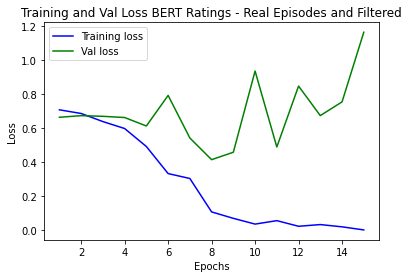

In [17]:
loss_train = losses
loss_val = losses_val
epochs = range(1,16)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='Val loss')
plt.title('Training and Val Loss BERT Ratings - Real Episodes and Filtered')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Sentiment_Loss_Real_Episodes')
plt.show()


## Test Evaluation

In [20]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


train_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)
pred= np.array([])

for batch in train_loader:
    with torch.no_grad():
      net.eval()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = net(input_ids, attention_mask=attention_mask)
        
      pred= np.append(pred,(torch.argmax(torch.softmax(torch.Tensor.cpu(outputs.logits).detach(),dim=1),dim=1)))
print(accuracy_score(test_labels,pred))
 
print(classification_report(test_labels,pred))


0.494949494949495
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       302
           1       0.49      0.51      0.50       292

    accuracy                           0.49       594
   macro avg       0.50      0.50      0.49       594
weighted avg       0.50      0.49      0.49       594

